## Task2: Reading the dataset file and building the input data structure <br>
In this example, we are reading the input file to prepre the dataset <br>
Each pair of sentence shall be passed together to the circuit evaluator, so must stick together <br>
Tuple in Python is the mpst convinient way to make pairs of data <br>
A list of tuples is created by: <br>
all_data = list(zip(all_sentences1[0:80], all_sentences2[0:80])) <br>


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 120
SEED = 2

In [3]:
import csv
def read_data(filename):
    labels, sentences1, sentences2 = [], [], []
    with open(filename) as f:
        for line in f:
            split_list = line.split(",")
            t = int(split_list[2])
            labels.append(t)
            sentences1.append(split_list[0])
            sentences2.append(split_list[1])
    return labels, sentences1, sentences2

all_labels, all_sentences1, all_sentences2 = read_data('MC1.TXT')
all_data = list(zip(all_sentences1[0:80], all_sentences2[0:80]))

train_labels, train_data1, train_data2 = all_labels[0: 80], all_sentences1[0: 80], all_sentences2[0: 80]
test_labels, test_data1, test_data2 = all_labels[80: 100], all_sentences1[80: 100], all_sentences2[80: 100]
test_data =  list(zip(test_data1[80:100], test_data2[80:100]))

In [ ]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_sentences1_diagrams = parser.sentences2diagrams(train_data1)
raw_train_sentences2_diagrams = parser.sentences2diagrams(train_data2)
raw_test_sentences1_diagrams = parser.sentences2diagrams(test_data1)
raw_test_sentences2_diagrams = parser.sentences2diagrams(test_data2)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


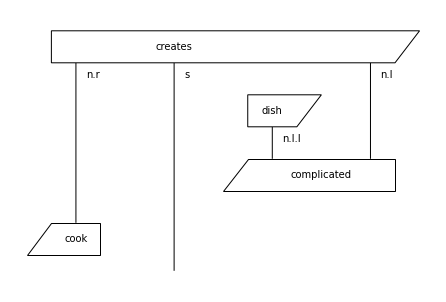

In [ ]:
from lambeq import remove_cups

train_s1_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences1_diagrams]
train_s2_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences2_diagrams]

test_s1_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences1_diagrams]
test_s2_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences2_diagrams]
train_s1_diagrams[0].draw()

In [ ]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_s1_circuits = [ansatz(diagram) for diagram in train_s1_diagrams]
train_s2_circuits = [ansatz(diagram) for diagram in train_s2_diagrams]

test_s1_circuits = [ansatz(diagram) for diagram in test_s1_diagrams]
test_s2_circuits = [ansatz(diagram) for diagram in test_s2_diagrams]
print(len(test_s2_circuits))

20


In [20]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_s1_circuits = train_s1_circuits+test_s1_circuits
all_s2_circuits = train_s2_circuits+test_s2_circuits
print(len(all_s1_circuits))
print(len(all_s2_circuits))
all_circuits = all_s1_circuits + all_s2_circuits
print(len(all_circuits))
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_s1_circuits, backend_config=backend_config)

100
100
200


In [21]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting


In [22]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [23]:
from lambeq import Dataset

train_dataset = Dataset(
            train_s1_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

test_dataset = Dataset(test_s1_circuits, test_labels, shuffle=False)
print(len(test_labels))

20


In [24]:
trainer.fit(train_dataset, test_dataset, logging_step=12)

ValueError: operands could not be broadcast together with shapes (30,) (30,2) 